Attila Cangi, 14.02.2020

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import integrate
from scipy import interpolate
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Parameters

In [2]:
# Temperature
temp = 298

# Fermi Level
fermi_energy = 7.770345

# Boltzmann's constant
k = 8.617333262145e-5

# Conversion factor from Rydberg to eV
Ry2eV = 13.6056980659

# Gaussian smearing in QE-DOS calculations
# taken from QE-DOS input file
sigma_qe = 0.032

Load eigenvalues and DOS from QE output

In [3]:
# filepath: blake.sandia.gov:/home/acangi/q-e_calcs/Al/datasets/vasp_econ_snapshots/298K/2.699g/170726180545.0/100Ry_k333
## Snapshot 0: Eigenvalues (from PW std output file, slurm-1006575.out)
### rows: band index, row i: eigs[i , :]
### cols: k points,   col j: eigs[: , j]
eigs_qe = np.loadtxt('snap_0/EIGS', delimiter=',')
k_weights_qe = np.loadtxt('snap_0/k_weights', delimiter=',')
## DOS
dos_qe = np.loadtxt('snap_0/Al.dos', skiprows=1)
## Snapshot 1: Eigenvalues (from PW std output file, slurm-1006846.out)
### rows: band index, row i: eigs[i , :]
### cols: k points,   col j: eigs[: , j]
eigs_qe_01 = np.loadtxt('snap_1/EIGS', delimiter=',')
k_weights_qe_01 = np.loadtxt('snap_1/k_weights', delimiter=',')
## DOS
dos_qe_01 = np.loadtxt('snap_1/Al.dos', skiprows=1)

Define functions

In [4]:
# Fermi-Dirac distribution function
def fd_function(energy, eF, t):                                                                                                 
    return 1.0 / (1.0 + np.exp((energy - eF) / (k * t)))

In [5]:
# Define Gaussian
## Note: Gaussian without factor of 1/sqrt(2)
def gaussian(en, eF, sigma):
    result = 1.0/np.sqrt(np.pi*sigma**2)*np.exp(-1.0*((en-eF)/sigma)**2)
    return result

In [6]:
# Define a discretized delta function that maintains 0th and 1st moments
def delta_M1(en, eF):
    de = en-eF
    de_above = np.min(de,initial=np.max(de),where=np.greater(de,0.0))
    de_below = np.max(de,initial=np.min(de),where=np.less_equal(de,0.0))
    result = 1.0 - np.abs(de)/(de_above-de_below)
    result = result*np.greater_equal(result,0.0)*np.less_equal(result,1.0)
    result = result/(de_above-de_below)
    return result

In [7]:
# Function generating DOS from eigenvalues
def gen_DOS(k_weights, array_en, array_eigs, sigma):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            ra_dos_ik[idx_bnd].append(gaussian(ra_en, array_eigs[idx_bnd , :][idx_k], sigma))
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [8]:
# Function generating DOS from eigenvalues
def gen_DOS_M1(k_weights, array_en, array_eigs):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            ra_dos_ik[idx_bnd].append(delta_M1(ra_en, array_eigs[idx_bnd , :][idx_k]))
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [9]:
# Function generating band energy from eigenvalues
def gen_EIG(k_weights, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## eig: band energy
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_fd = fd_function(array_eigs, eF=E_fermi, t=temperature)
    eig = 0.0
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            # Sum the Gaussians over idx_band and idx_k
            eig += k_weights[idx_k]*array_eigs[idx_bnd , :][idx_k]*ra_fd[idx_bnd , :][idx_k]  
    return eig

In [10]:
# Function generating number of electrons from eigenvalues
def gen_NUM(k_weights, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## num: number of electrons
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_fd = fd_function(array_eigs, eF=E_fermi, t=temperature)
    num = 0.0
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            # Sum the Gaussians over idx_band and idx_k
            num += k_weights[idx_k]*ra_fd[idx_bnd , :][idx_k]  
    return num

In [11]:
eband_ref=gen_EIG(k_weights_qe, eigs_qe)
print(eband_ref)

2595.7730052436877


In [12]:
enum_ref=gen_NUM(k_weights_qe, eigs_qe)
print(enum_ref)

768.0000498916445


In [13]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband(k_weights, array_en, array_eigs, sigma, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    #eband = sp.integrate.simps(ra_dos*array_en*ra_fd, array_en)
    eband = sp.integrate.trapz(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [14]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_M1(k_weights, array_en, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    ra_dos = gen_DOS_M1(k_weights_qe, array_en, eigs_qe)
    eband = sp.integrate.trapz(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [15]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def gen_enum(k_weights, array_en, array_eigs, sigma, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    enum = sp.integrate.trapz(ra_dos*ra_fd, array_en)
    return enum

In [16]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def gen_enum_M1(k_weights, array_en, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    ra_dos = gen_DOS_M1(k_weights_qe, array_en, eigs_qe)
    enum = sp.integrate.trapz(ra_dos*ra_fd, array_en)
    return enum

In [68]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_int(k_weights, array_en, array_eigs, sigma, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    f_dos = sp.interpolate.interp1d(array_en,ra_dos)
    eband, abserr = sp.integrate.quad(
        lambda e: f_dos(e)*e*fd_function(e, eF=E_fermi, t=temperature),
        array_en[0],array_en[-1],limit=500,points=(E_fermi))
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [69]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_int_M1(k_weights, array_en, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    ra_dos = gen_DOS_M1(k_weights_qe, array_en, eigs_qe)
    f_dos = sp.interpolate.interp1d(array_en,ra_dos)
    eband, abserr = sp.integrate.quad(
        lambda e: f_dos(e)*e*fd_function(e, eF=E_fermi, t=temperature),
        array_en[0],array_en[-1],limit=500,points=(E_fermi))
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [70]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def gen_enum_int(k_weights, array_en, array_eigs, sigma, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    f_dos = sp.interpolate.interp1d(array_en,ra_dos)
    enum, abserr = sp.integrate.quad(
        lambda e: f_dos(e)*fd_function(e, eF=E_fermi, t=temperature),
        array_en[0],array_en[-1],limit=500,points=(E_fermi))
    return enum

In [71]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def gen_enum_int_M1(k_weights, array_en, array_eigs, E_fermi = fermi_energy, temperature = temp):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## E_fermi: fermi_energy used in generating the occupations
    ## temperature: temperature used in generating the occupations
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=E_fermi, t=temperature)
    ra_dos = gen_DOS_M1(k_weights_qe, array_en, eigs_qe)
    f_dos = sp.interpolate.interp1d(array_en,ra_dos)
    enum, abserr = sp.integrate.quad(
        lambda e: f_dos(e)*fd_function(e, eF=E_fermi, t=temperature),
        array_en[0],array_en[-1],limit=500,points=(E_fermi))
    return enum

Compute the DOS from its naive definition
$$ D(E) = \sum_i \sum_k w_k\, \delta(\epsilon-\epsilon_{ik})$$
where $i$ labels the band and $k$ the k point. We represent the $\delta$-functions as a Gaussian
$$\delta(\epsilon-\epsilon_{ik}) = \frac{1}{\sqrt{\pi\sigma^2}}\exp{\left[-\left(\frac{\epsilon-\epsilon_{ik}}{\sigma}\right)^2\right]}$$ 
with a width $\sigma$.

Compute total DOS

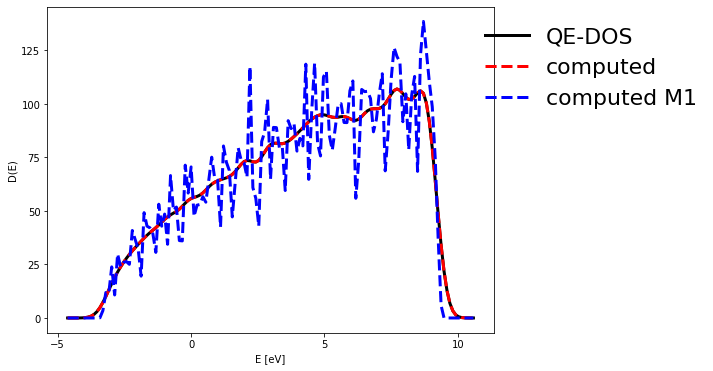

In [17]:
# Generate data
ra_en = dos_qe[: , 0]
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_qe*Ry2eV )
ra_en_M1 = ra_en[::1]
ra_dos_M1 = gen_DOS_M1(k_weights_qe, ra_en_M1, eigs_qe )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en,  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en , ra_dos,        linestyle='--', linewidth=3, color='red',  label='computed')
ax.plot(ra_en_M1, ra_dos_M1,     linestyle='--', linewidth=3, color='blue',  label='computed M1')


# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

We recover the QE-DOS result by using the same parameters as in the input for computing the DOS.
Now we can go ahead and investigate different energy grids and smearing values in order to improve upon the band energy and achieve better agreement with the band-energy output of QE.

The "band energy" (or better, sum of eigenvalues) is defined as

$$E_{band} = \int_{-\infty}^{\infty} dE\ D(E)\, f(E)\, E$$

where $E$ denotes the energy, $D(E)$ the DOS, $f(E)$ the Fermi-Dirac distribution function.

The "band energy" is also called the "single-particle energy" or the "one-electron energy" and is obtained from summing the eigenvalues

$$E_{band} = \sum_i \epsilon_i\ .$$

For look at the particular values for a given snapshot (data from ```blake.sandia.gov:/home/acangi/q-e_calcs/Al/datasets/vasp_econ_snapshots/298K/2.699g/170726180545.0/100Ry_k333```). QE prints the one-electron energy in the standard output, together with all the other energy contributions, e.g., 
```
The total energy is the sum of the following terms:                                                  


     one-electron contribution =     737.82754675 Ry
     hartree contribution      =       4.77073244 Ry
     xc contribution           =    -554.09988814 Ry
     ewald contribution        =   -1375.56724973 Ry
     smearing contrib. (-TS)   =      -0.02019845 Ry
```
However, what QE prints as the "one-electron contribution" is not the sum of the eigenvalues, but instead (see source code ```~/PW/src/electrons.f90``` lines 638-640)

$$\text{one-electron contribution} = \sum_i \epsilon_i - (E_h + E_{xc})$$

In order to correctly compare the band energy obtained from integrating the DOS with the QE output we need to add the hartree and exchange-correlation contributions to the one-electron contribution.

In [18]:
737.82754675

737.82754675

The correct band energy from QE output is

In [19]:
eband_qe = 737.82754675+4.77073244-554.09988814
print(eband_qe)

188.49839105


In [20]:
emin = dos_qe[: , 0][0] - 1.0
emax = dos_qe[: , 0][-1] + 1.0
n_egrid_max = int(len(dos_qe[:,0]))
#n_egrids = np.int32(np.arange(1,11)/10.0*n_egrid_max)
n_egrids = np.arange(10,n_egrid_max)
ra_enum = []
ra_eband = []
ra_enum_M1 = []
ra_eband_M1 = []
for n_egrid in n_egrids:
   ra_en = np.linspace(emin, emax, n_egrid)
   sigma_mod = ra_en[1] - ra_en[0]
   # Generate electron number 
   ra_enum = np.append(ra_enum,gen_enum(k_weights_qe, ra_en, eigs_qe, sigma_mod, E_fermi = 15.0) - gen_NUM(k_weights_qe, eigs_qe, E_fermi = 15.0))
   # Generate band energy
   ra_eband = np.append(ra_eband,gen_eband(k_weights_qe, ra_en, eigs_qe, sigma_mod, E_fermi = 15.0)*Ry2eV - gen_EIG(k_weights_qe, eigs_qe, E_fermi = 15.0))
   # Generate electron number 
   ra_enum_M1 = np.append(ra_enum_M1,gen_enum_M1(k_weights_qe, ra_en, eigs_qe, E_fermi = 15.0) - gen_NUM(k_weights_qe, eigs_qe, E_fermi = 15.0))
   # Generate band energy
   ra_eband_M1 = np.append(ra_eband_M1,gen_eband_M1(k_weights_qe, ra_en , eigs_qe, E_fermi = 15.0)*Ry2eV - gen_EIG(k_weights_qe, eigs_qe, E_fermi = 15.0))
   print("{0}  {1}  {2}  {3}  {4}".format(n_egrid,ra_enum[-1],ra_enum_M1[-1],ra_eband[-1],ra_eband_M1[-1]))


10  -5.234489245958457  -1.1743850336642936e-10  -45.807938886497595  1.8189894035458565e-12
11  -3.0085239583360135  -1.184616849059239e-10  -26.794918722090188  -5.002220859751105e-12
12  -1.6938272863526436  -1.1732481652870774e-10  -15.31026468328173  2.7284841053187847e-12
13  -0.9298947758965141  -1.1789325071731582e-10  -8.515658528185668  -4.547473508864641e-13
14  -0.49824413626174646  -1.1789325071731582e-10  -4.599498588736424  9.094947017729282e-13
15  -0.26069453180468827  -1.1800693755503744e-10  -2.4242788304977694  -4.547473508864641e-13
16  -0.13643360852029218  -1.1743850336642936e-10  -1.2616944080477879  3.183231456205249e-12
17  -0.06895619423528387  -1.1743850336642936e-10  -0.6568335573683726  9.094947017729282e-13
18  -0.03418726555844387  -1.1857537174364552e-10  -0.32203098547824993  -2.7284841053187847e-12
19  -0.011282068307764348  -1.1789325071731582e-10  -0.12597016910467573  4.547473508864641e-13
20  -0.007201335063200531  -1.177795638795942e-10  -0.06170

95  -0.0011109472937960163  -1.1789325071731582e-10  0.00441628471844524  4.547473508864641e-13
96  0.00016933372432959004  -1.1789325071731582e-10  -0.0005063980133854784  4.547473508864641e-13
97  2.85445787540084e-06  -1.1789325071731582e-10  -0.002920579854162497  4.547473508864641e-13
98  -7.979905831234646e-06  -1.1800693755503744e-10  -0.0003530890285219357  -4.547473508864641e-13
99  0.000559094152436046  -1.1789325071731582e-10  0.0031685118592577055  9.094947017729282e-13
100  0.001027479174013024  -1.1789325071731582e-10  0.007263485191288055  4.547473508864641e-13
101  -0.001116513069746361  -1.1800693755503744e-10  -0.0050331918878328  -4.547473508864641e-13
102  -0.0006489360438308722  -1.1789325071731582e-10  -0.00699392353044459  -4.547473508864641e-13
103  -0.0006882263490979312  -1.1812062439275905e-10  -0.0034550372265584883  -4.547473508864641e-13
104  0.001200238797878228  -1.1800693755503744e-10  0.008152729330959119  -2.2737367544323206e-12
105  0.000827325944783

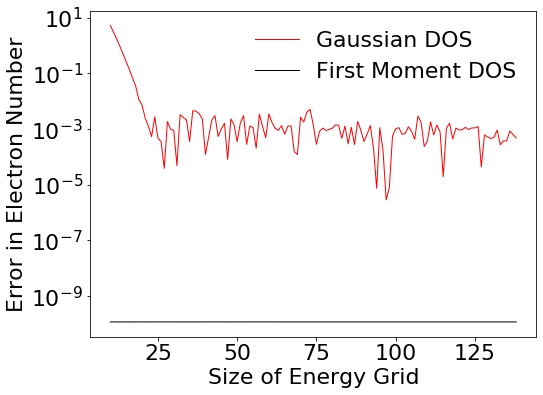

In [24]:
# Plot electron number errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Electron Number')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_enum), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_enum_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_num_vs_N_grid_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

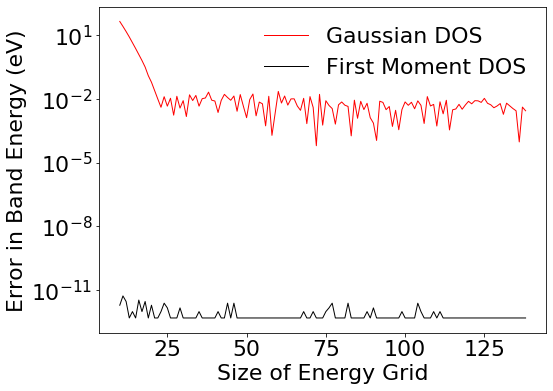

In [26]:
# Plot band energy errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Band Energy (eV)')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_eband), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_eband_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_band_vs_N_grid_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

In [28]:
emin = dos_qe[: , 0][0] - 1.0
emax = dos_qe[: , 0][-1] + 1.0
n_egrid_max = int(len(dos_qe[:,0]))
#n_egrids = np.int32(np.arange(1,11)/10.0*n_egrid_max)
n_egrids = np.arange(10,n_egrid_max)
ra_enum = []
ra_eband = []
ra_enum_M1 = []
ra_eband_M1 = []
for n_egrid in n_egrids:
   ra_en = np.linspace(emin, emax, n_egrid)
   sigma_mod = ra_en[1] - ra_en[0]
   # Generate electron number 
   ra_enum = np.append(ra_enum,gen_enum(k_weights_qe, ra_en, eigs_qe, sigma_mod) - enum_ref)
   # Generate band energy
   ra_eband = np.append(ra_eband,gen_eband(k_weights_qe, ra_en, eigs_qe, sigma_mod)*Ry2eV - eband_ref)
   # Generate electron number 
   ra_enum_M1 = np.append(ra_enum_M1,gen_enum_M1(k_weights_qe, ra_en, eigs_qe) - enum_ref)
   # Generate band energy
   ra_eband_M1 = np.append(ra_eband_M1,gen_eband_M1(k_weights_qe, ra_en , eigs_qe)*Ry2eV - eband_ref)
   print("{0}  {1}  {2}  {3}  {4}".format(n_egrid,ra_enum[-1],ra_enum_M1[-1],ra_eband[-1],ra_eband_M1[-1]))


10  2.2844601319465028  16.296672267803615  -31.5760293714593  126.32406658093532
11  -51.07276969076406  -50.93051740535441  -464.8976302275223  -422.3963633530029
12  -12.617757114842561  -11.331995734633779  -165.7696424022165  -120.16216349047363
13  19.438226077840454  21.8087115071487  94.92524901155366  144.6263508188281
14  46.001438205327986  51.421265754918295  319.03681048251383  389.8194781820275
15  -49.51921831823677  -50.677594031309695  -417.80241810279404  -401.3243152956279
16  -21.62432515936166  -22.112666764344908  -205.71928241672822  -187.74413272350694
17  3.833245985509393  3.517760524066489  -5.312123682076617  11.431645774023764
18  26.402839965808198  27.10744314317617  177.57206300248208  200.71705587410042
19  7.342617454117772  7.294689499493643  40.56041050339218  56.46768007854416
20  -27.97135342934098  -28.708932084874505  -239.1490731216877  -230.85355150670193
21  -7.142532683850959  -7.547194104271057  -78.334210310858  -69.1433146302038
22  11.925

109  0.29219512948805004  0.7502252984742199  1.6191282202021284  5.693631240757895
110  -1.7293844850763662  -1.5842363392348489  -14.145657927382672  -12.506592987315798
111  -1.2633904726218361  -1.213897331353337  -10.658278606282238  -9.794505900155855
112  0.5712791670318893  0.8646335836276648  3.597423014852666  6.358180364034979
113  1.0149553047489235  1.467350135315428  7.208174692555531  11.200508907802941
114  -0.7649856336010998  -0.4731751859153519  -6.543294953270561  -3.8024365582868995
115  -1.6282378032370843  -1.5934170162646524  -13.37910224058578  -12.64381583077693
116  -0.32847751256917945  -0.192777248234961  -3.3445826962179126  -1.8523984913326785
117  0.9670622329313119  1.3267142433576282  6.8005195477221605  10.039752135971412
118  0.24449778848463666  0.637634835933568  1.3255816748396683  4.824437433661842
119  -1.3251309329752985  -1.2024464414889735  -10.900954370308682  -9.513979101207042
120  -1.0339219833242623  -1.0012340452080934  -8.7526964308017

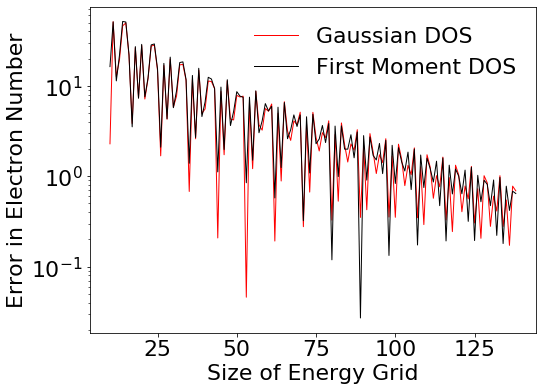

In [30]:
# Plot electron number errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Electron Number')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_enum), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_enum_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_num_vs_N_grid_RT_Fermi_function.png',dpi=100,bbox_inches='tight')
plt.show()

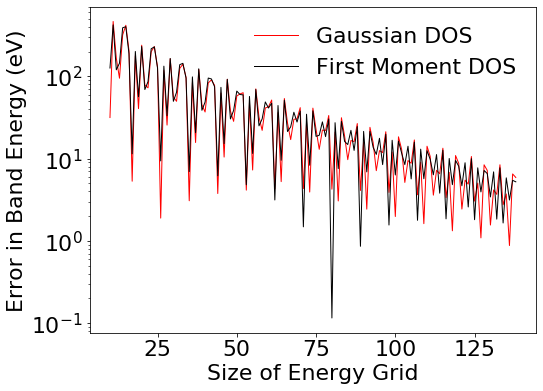

In [32]:
# Plot band energy errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Band Energy (eV)')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_eband), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_eband_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_band_vs_N_grid_RT_Fermi_function.png',dpi=100,bbox_inches='tight')
plt.show()

In [72]:
emin = dos_qe[: , 0][0] - 1.0
emax = dos_qe[: , 0][-1] + 1.0
n_egrid_max = int(len(dos_qe[:,0]))
#n_egrids = np.int32(np.arange(1,11)/10.0*n_egrid_max)
n_egrids = np.arange(10,n_egrid_max)
ra_enum = []
ra_eband = []
ra_enum_M1 = []
ra_eband_M1 = []
for n_egrid in n_egrids:
   ra_en = np.linspace(emin, emax, n_egrid)
   sigma_mod = ra_en[1] - ra_en[0]
   # Generate electron number 
   ra_enum = np.append(ra_enum,gen_enum_int(k_weights_qe, ra_en, eigs_qe, sigma_mod) - enum_ref)
   # Generate band energy
   ra_eband = np.append(ra_eband,gen_eband_int(k_weights_qe, ra_en, eigs_qe, sigma_mod)*Ry2eV - eband_ref)
   # Generate electron number 
   ra_enum_M1 = np.append(ra_enum_M1,gen_enum_int_M1(k_weights_qe, ra_en, eigs_qe) - enum_ref)
   # Generate band energy
   ra_eband_M1 = np.append(ra_eband_M1,gen_eband_int_M1(k_weights_qe, ra_en , eigs_qe)*Ry2eV - eband_ref)
   print("{0}  {1}  {2}  {3}  {4}".format(n_egrid,ra_enum[-1],ra_enum_M1[-1],ra_eband[-1],ra_eband_M1[-1]))


<ipython-input-70-8a6926920a1f>:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  enum, abserr = sp.integrate.quad(
<ipython-input-71-f88ccd089cb6>:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  enum, abserr = sp.integrate.quad(
<ipython-input-69-406642d18193>:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  eband, abserr = sp.integrate.quad(


10  -13.279457382996725  -1.5943287158244175  -204.99901992889727  -73.64132975782468
11  -10.584905418379662  -3.3596062347261295  -170.35528764235596  -76.26173069497872


<ipython-input-68-1320dc5caf38>:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  eband, abserr = sp.integrate.quad(


12  -7.622572447322909  -3.2910656504813005  -135.78485770069528  -67.63305431379604
13  -4.958764023423441  -2.3245302207935765  -105.08001968634562  -53.79662825543892
14  -3.338969396864286  -0.8014179529504872  -83.82751336060619  -36.63252201057048
15  -3.0658370744960166  -0.5376671044202794  -74.48984024576794  -30.75794666310685
16  -2.7000378202089905  -0.7014599707579237  -65.73139962042387  -29.078775773406505
17  -2.0273009942399085  -1.1582635551835665  -55.54811007212311  -29.840695007916565
18  -1.3925325945957638  -0.9418433490864118  -46.312441692213724  -25.32366446955257
19  -1.201152508004725  -1.4583033871500675  -41.13879844898838  -27.25127105671436
20  -1.3217698372741324  -1.3978542702327559  -38.93848348297706  -25.66185703090696
21  -1.257249997465692  -1.1708179852660123  -35.78022213915847  -22.850744348056196
22  -1.1049646003036742  -0.7915625320466688  -32.26358493472799  -18.31166365280751
23  -1.0283864172432686  -1.0326549550003392  -29.62607912091744

108  -0.44286042031683337  -0.1037300245809547  -4.500521893400219  -1.3516501266130945
109  -0.4439179699379565  -0.051027761327418375  -4.481829759047741  -0.9216857833230279
110  -0.4543494800495864  -0.24935489044241876  -4.545376784458313  -2.4532639539438605
111  -0.44671147246424425  -0.33533304786465123  -4.460577104154254  -3.1230413028438306
112  -0.41772049124017485  -0.164396656658937  -4.233148099609025  -1.7846952268432688
113  -0.4027067168964322  -0.040836430824697345  -4.09362561606531  -0.8141260736360891
114  -0.41319560481281314  -0.12055674101497971  -4.1485584397964885  -1.4139214477650057
115  -0.41696081913653416  -0.29846533339912185  -4.1630660694791  -2.7959490024195475
116  -0.3995875285080501  -0.23395902631011722  -4.019822922894946  -2.2929065583371084
117  -0.37273399902676374  -0.07057378414208415  -3.7982999969399316  -1.0132232051360006
118  -0.3715862652126134  -0.036633393248052926  -3.7715158643231916  -0.7366933655202956
119  -0.383609748889171  -

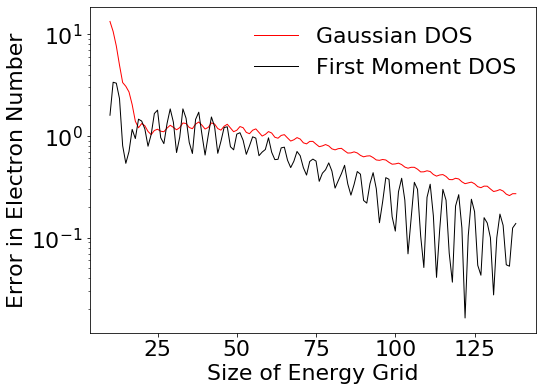

In [73]:
# Plot electron number errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Electron Number')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_enum), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_enum_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_num_vs_N_grid_RT_Fermi_function_integrated.png',dpi=100,bbox_inches='tight')
plt.show()

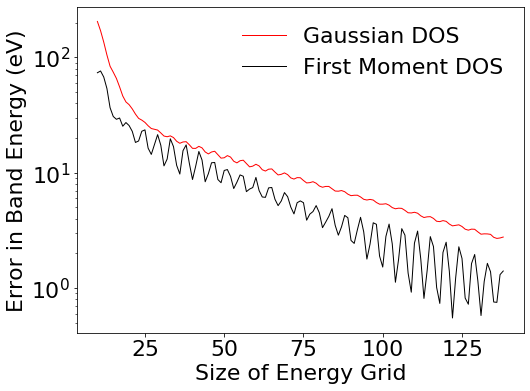

In [74]:
# Plot band energy errors using the two DOS definitions        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Band Energy (eV)')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(n_egrids, np.abs(ra_eband), linestyle='-',  linewidth=1, color='red',  label='Gaussian DOS')
ax.plot(n_egrids, np.abs(ra_eband_M1), linestyle='-',  linewidth=1, color='black', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('E_band_vs_N_grid_RT_Fermi_function_integrated.png',dpi=100,bbox_inches='tight')
plt.show()

In [ ]:
# Generate band energy
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Generate band energy
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*0.79255
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
ewidth = dos_qe[: , 0][1]-dos_qe[: , 0][0]
print(ewidth)

In [ ]:
10e-3/Ry2eV

In [ ]:
ewidth*Ry2eV

In [ ]:
dos_qe[: , 0]

In [ ]:
#ewidth=dos_qe[: , 0][1]-dos_qe[: , 0][0]
ewidth = (dos_qe[: , 0][1]-dos_qe[: , 0][0])*0.5
print(ewidth)
ra_sigma = np.linspace(0.5*ewidth, 5*ewidth, 11)
ra_enum = np.zeros(len(ra_sigma))
ra_eband = np.zeros(len(ra_sigma))
ra_en = np.linspace(dos_qe[0, 0], dos_qe[-1, 0], int((dos_qe[-1, 0]-dos_qe[0, 0])/ewidth)) 
for i in range(len(ra_sigma)):
    print("i:", i)
    # Generate electron number 
    ra_enum[i] = gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[i])
    # Generate band energy
    ra_eband[i] = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=ra_sigma[i])
print(ra_en[1]-ra_en[0])
print(ra_enum)
print(ra_eband)

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

#ax.set_ylim(767.95, 768.05)

ax.hlines(enum_ref, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.plot(ra_sigma,  ra_enum, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})


ax.hlines(eband_ref/Ry2eV, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.scatter(ra_sigma,  ra_eband, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()
print(np.min(abs(ra_eband-eband_ref/Ry2eV))/256)

In [ ]:
print(4*ra_sigma[0])

In [ ]:
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[1] )

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=1, color='red',  label='computed (adjusted width)')
ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=1, color='black', label='QE-DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

In [ ]:
# Generate electron number 
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*0.79255
gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )

Error in band energy compared to QE output

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

By adjusting the width of the Gaussian smearing we achieved the desired accuracy in the band energy, here < 1 meV.
The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

However, we can also increase the smearing width and also obtain an accurate band energy.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]
emax = dos_qe[: , 0][-1]
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*29.177
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

We can also generate a different energy grid. However, it the integral quickly converges with respect to the number of grid points. We can increase the range of the enegy grid to make sure the DOS decays to zero at the limits.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*29.908
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

Check for another snapshot.
The band energy from the QE output of snapshot 1 is:

In [ ]:
eband_qe_01 = 739.08601067+4.18224128-553.98606038
print(eband_qe_01)

In [ ]:
ewidth_01=dos_qe_01[: , 0][1]-dos_qe_01[: , 0][0]
print(ewidth_01)
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
ra_en_01 = np.linspace(emin, emax, int(len(dos_qe_01[: , 0])))
ra_sigma_01 = np.linspace(20*ewidth_01, ewidth_01, 101)
ra_enum_01 = np.zeros(len(ra_sigma_01))
ra_eband_01 = np.zeros(len(ra_sigma_01))
for i in range(len(ra_sigma)):
    ra_en_01 = dos_qe[: , 0]
    # Generate electron number 
    ra_enum_01[i] = gen_enum(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
    # Generate band energy
    ra_eband_01[i] = gen_eband(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
print(ra_enum_01)
print(ra_eband_01)

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(768, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_enum_01, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(eband_qe_01, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_eband_01, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Generate band energy
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, 2*int(len(dos_qe_01[: , 0])))
sigma_mod = sigma_qe*22.90#22.882
eband_01 = gen_eband(k_weights_qe_01, ra_en , eigs_qe_01, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband_01))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error_01 = eband_01-eband_qe_01
print("Error in Rydberg", eband_error_01)
print("Error in eV", eband_error_01*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe_01, ra_en, eigs_qe_01, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe_01[: , 0], dos_qe_01[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en           , ra_dos,           linestyle='-',  linewidth=3, color='red',   label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

This illustrates the issue with Gaussian smearing. The smearing width differs between the different snapshots. This means we cannot choose a fixed smearing width and obtain high accuracy in the band energy throughout a priori (i.e. without knowing the true value of the band energy). However, this might be fine, since we need to choose the smearing width only for the generation of training data. It might be somewhat inconvenient, but for each snapshot in the training data we can find the corresponding smearing width which will yield a band energy up to a target accuracy.

# Scratchpad

To do
* Perform search over smearing width using sp.optimize library. But this requires adapting the definitions of the functions above.
* Different representation of the $\delta$ function, for example Marzari-Vanderbilt (MV).

In [ ]:
# Define MV representation of delta function
def MV(en, mu, sigma):
    x = (mu-en)/sigma
    result = 1.0/np.sqrt(np.pi)*(2.0-np.sqrt(2)*x)*np.exp(-1.0*(x-(1.0/np.sqrt(2)))**2)
    return result

In [ ]:
# Sanity check of smearing functions
# Generate data
ra_en = np.linspace(7.,9.,601)
ra_gaussian = gaussian(ra_en, eF=fermi_energy, sigma=sigma_qe)
ra_MV = MV(ra_en, mu=fermi_energy, sigma=sigma_qe*2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en, ra_MV, linestyle='-',  linewidth=3, color='red', label='MV')
#ax.plot(ra_en, ra_gaussian, linestyle='-',  linewidth=3, color='blue', label='gaussian')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating DOS from eigenvalues
def gen_DOS_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            if (smearing_type == 1):
                smearing = gaussian(en=array_en, eF=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            elif (smearing_type == 2):
                smearing = MV(en=array_en, mu=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            else:
                print("Error, choose valid smearing function.")
            ra_dos_ik[idx_bnd].append(smearing)
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [ ]:
# Generate data
ra_en = dos_qe[: , 0]
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_qe*Ry2eV,smearing_type=2)

# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='--', linewidth=3, color='red',  label='computed')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=fermi_energy, t=temp)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS_ST(k_weights_qe, array_en, eigs_qe, sigma, smearing_type)
    eband = sp.integrate.trapz(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*30.56825
eband = gen_eband_ST(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod, smearing_type=2)
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

In [ ]:
# Generate data
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod, smearing_type=2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()